1. We are using vgg16 network
2. This notebook was written on colab
3. content image - https://3.img-dpreview.com/files/p/TS1200x900~sample_galleries/1330372094/1693761761.jpg
4. style image - https://skyryedesign.com/wp-content/uploads/2016/06/1000charuk-famous-artist-watercolor-artists-new-artists-painting-artists-art-painting-painter-artist.jpg
5. apart from content and style loss we define a total variation loss which reduces the noise of output image.

In [2]:
!pip install -U scipy==1.2.0

     |████████████████████████████████| 26.6MB 114kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [0]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import matplotlib.pyplot as plt
from io import BytesIO
from google.colab import files
from tqdm import tqdm


###setting height and width of the image


In [0]:
height = 512
width = 512

### Load the content image



Saving content_image.jpg to content_image (3).jpg


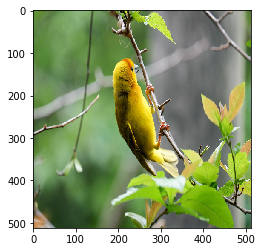

In [37]:
#via colab
uploaded = files.upload()
im = Image.open(BytesIO(uploaded[list(uploaded.keys())[0]] ))

#via local notebook
# content_image_path = 'content.jpg'
# content_image = Image.open(content_image_path)

content_image = im.resize((width, height))
plt.imshow(content_image)
plt.show()


### Load the style image


Saving style_image.jpg to style_image (1).jpg


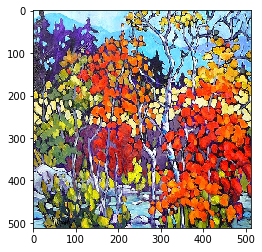

In [32]:
#via colab
uploaded = files.upload()
im = Image.open(BytesIO(uploaded[list(uploaded.keys())[0]]))

#via local notebook
# style_image_path  = 'style.jpg'
# style_image  = Image.open(style_image_path )

style_image  = im.resize((width, height))
plt.imshow(style_image)


###Convert images to 4_D array


In [45]:
content_array = np.asarray(content_image, dtype= 'float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype= 'float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


###1) Subtract the mean RGB value from each channel in the input
**why** ? - https://stackoverflow.com/questions/48201735/why-does-vgg19-subtract-the-mean-rgb-values-of-inputs
###2) Flip the multidimensional array from RGB to BGR
**why** ? - vgg16 is trained on caffe and it used opencv which loads image in brg by default. ->https://github.com/jcjohnson/neural-style/issues/207

In [0]:

content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

##Backend variables in Keras Backend

In [47]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))
print(content_image)
print(style_image)
print(combination_image)

<tf.Variable 'Variable_3:0' shape=(1, 512, 512, 3) dtype=float32_ref>
<tf.Variable 'Variable_4:0' shape=(1, 512, 512, 3) dtype=float32_ref>
Tensor("Placeholder_27:0", shape=(1, 512, 512, 3), dtype=float32)


###Concatenate all image data into a single tensor
we'll feed this whole tensor into the vgg16 and get feature representation from various middle layers instead of the final output.

In [48]:
input_tensor = backend.concatenate([content_image, style_image, combination_image], axis = 0)
print(input_tensor)


Tensor("concat_1:0", shape=(3, 512, 512, 3), dtype=float32)


###model object without the top layers/fully connected layers
Model initlization

In [11]:
model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top = False)





58892288/58889256 [==============================] - 2s 0us/step








In [49]:
#dict containing name of layers and respective outputs for input tensor define in upper cells.
layers = dict([(layer.name, layer.output) for layer in model.layers])
print(layers)

{'input_1': <tf.Tensor 'concat:0' shape=(3, 512, 512, 3) dtype=float32>, 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>, 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>, 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>, 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>, 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>, 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>, 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>, 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>, 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>, 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>, 'block4_conv1': <tf.Tensor 'b

In [0]:
#Defining alpha and beta hyperparameters
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

In [0]:
#Instantiates a variable and returns it. https://www.tensorflow.org/api_docs/python/tf/keras/backend/variable
loss = backend.variable(0.)

#Loss Functions

##Content Loss
![Imgur](https://i.imgur.com/ahYHnUs.jpg)

In [0]:
def content_loss(content, combination):
    '''
    half of summation of square of difference between feature representation of 
    generated image and content image.
    '''
    return (1/2)*backend.sum(backend.square(combination - content))

In [0]:
layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

In [0]:
loss = loss + content_weight * content_loss(content_image_features, combination_features)


##The style loss
![Imgur](https://i.imgur.com/Nax3jto.jpg)

In [0]:

def gram_matrix(x):
    '''
    batch_flatten - Turn a nD tensor into a 2D tensor with same 0th dimension.
    rearrange the dimentions from 0,1,2 to 2,0,1 and 2D flatten it
    that is a 5*4*3 image to 3*4*5 to 3*20
    then dot product of 2D vector with it's transpose.
    '''
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

def style_loss(style, combination):
    '''
    summation of square of difference between gram marices of generated image 
    and style image divided by some constant.
    '''
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [0]:
#VGG16 layers used
feature_layers = ['block1_conv2', 'block2_conv2', 
                  'block3_conv3', 'block4_conv3', 
                  'block5_conv3']

In [0]:
#style loss is computed for all layers mentioned above to compute similarity between all those layer's channels.
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, : ,: ,:]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

In [0]:
# def total_variation_loss(x):
#     '''
#     This loss is defined to lessen the noise of generated image
#     '''
#     a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
#     b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
#     return backend.sum(backend.pow(a + b, 1.25))


In [0]:
# loss += total_variation_weight * total_variation_loss(combination_image)



In [0]:
#Returns the gradients of loss w.r.t. variables.

grads = backend.gradients(loss, combination_image)


In [59]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs) #Instantiates a Keras function.

TypeError: ignored

In [0]:
def eval_loss_and_grads(x):
    '''
    takes input a combination of all three images and return
    loss and gradients
    '''
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

In [0]:
class Evaluator(object):
    '''
    loss function assigns loss and grad values for x tensor if loss and grad
    are null.
    grad function return local grad value and make object's grad and loss null
    if they're not null
    '''

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [0]:
#a object of the class defined above
evaluator = Evaluator()


In [62]:
#returns a array of shape (1,height,width,3) between values (0-128) - (255-128)
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.
print(x.shape)
print(x)

(1, 512, 512, 3)
[[[[ -86.43513848   28.1744387  -119.91529778]
   [ 102.06673379   35.19382141 -118.92935472]
   [ -28.29807422   58.11351286 -123.39343486]
   ...
   [ -16.918691    -83.61198486    8.43884062]
   [-111.89338467 -124.36017165   59.9964267 ]
   [-104.69732437  -52.94416503  -19.16891194]]

  [[ -61.53330402 -104.99152664  -82.24325978]
   [  57.34996244 -111.74273298  -23.42541243]
   [  19.89040381   -1.04678698  -50.34846518]
   ...
   [ -21.06800382  -97.79549072  -88.19282847]
   [ -82.10272102   38.7169007  -102.98027144]
   [  43.04714356  -99.01257422  -62.63624968]]

  [[  76.56834104   63.6407858  -114.54436442]
   [-126.0880498  -119.917413    -48.86873403]
   [ -57.30351968    9.12472291   -2.81506497]
   ...
   [ -86.13401997  -28.27872616  -65.55477474]
   [-101.01417508   -8.7660678    36.03387162]
   [  36.40560857 -108.12923744  121.39008555]]

  ...

  [[  15.39512666   21.22085813  -15.18594208]
   [ 117.32658446   40.38298826 -121.19864974]
   [  90.

## fmin_l_bfgs_b(func, x0, fprime, maxfun) - Minimize a function func using the L-BFGS-B algorithm.


###1. func - Function to minimise.
###2. x0 - initialized array (x above)
###3. fprime - The gradient of func
###4. maxfun - Maximum number of function evaluations.




In [27]:
iterations = 15

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun = 20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 152319840000.0
Iteration 0 completed in 11s
Start of iteration 1
Current loss value: 100301980000.0
Iteration 1 completed in 4s
Start of iteration 2
Current loss value: 81954120000.0
Iteration 2 completed in 4s
Start of iteration 3
Current loss value: 73932956000.0
Iteration 3 completed in 4s
Start of iteration 4
Current loss value: 69445570000.0
Iteration 4 completed in 4s
Start of iteration 5
Current loss value: 65485440000.0
Iteration 5 completed in 4s
Start of iteration 6
Current loss value: 62373450000.0
Iteration 6 completed in 4s
Start of iteration 7
Current loss value: 60617933000.0
Iteration 7 completed in 4s
Start of iteration 8
Current loss value: 59296956000.0
Iteration 8 completed in 4s
Start of iteration 9
Current loss value: 57917450000.0
Iteration 9 completed in 4s
Start of iteration 10
Current loss value: 57102150000.0
Iteration 10 completed in 4s
Start of iteration 11
Current loss value: 56438145000.0
Iteration 11 completed in 

In [0]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

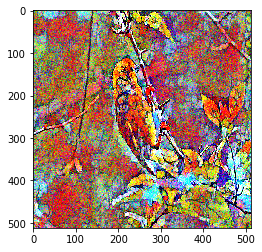

In [29]:
Image.fromarray(x)

# from scipy.misc import imsave
# imsave('sloth_sketch.jpg', x)

import matplotlib.pyplot as plt
plt.imshow(x)

## Finally a function to do it all in one go

In [0]:
def check_for_other_outputs(iterations):
  '''
  Loads content and style image and returns target image
  takes some time because of training
  '''
  uploaded = files.upload()
  im = Image.open(BytesIO(uploaded[list(uploaded.keys())[0]]))
  #via local notebook
  # content_image_path = 'content.jpg'
  # content_image = Image.open(content_image_path)

  content_image = im.resize((width, height))
  #via colab
  uploaded = files.upload()
  im = Image.open(BytesIO(uploaded[list(uploaded.keys())[0]]))
  #via local notebook
  # style_image_path  = 'style.jpg'
  # style_image  = Image.open(style_image_path )
  style_image  = im.resize((width, height))

  x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

  for i in tqdm(range(iterations)):
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun = 20)
  x = x.reshape((height, width, 3))
  x = x[:, :, ::-1]
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = np.clip(x, 0, 255).astype('uint8')
  Image.fromarray(x)
  plt.imshow(content_image)
  plt.axis('off')
  plt.show()
  plt.imshow(style_image)
  plt.axis('off')
  plt.show()
  plt.imshow(x)
  plt.axis('off')
  plt.show()

Saving content_image.jpg to content_image (7).jpg


Saving style_image.jpg to style_image (6).jpg


100%|██████████| 15/15 [01:05<00:00,  4.44s/it]


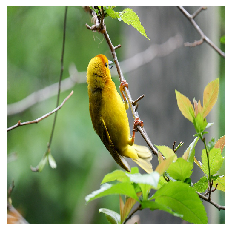

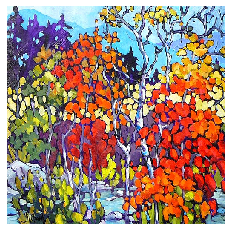

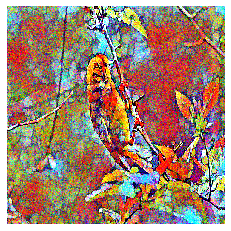

In [71]:
check_for_other_outputs(15)

Saving content_image.jpg to content_image (8).jpg


Saving style_image.jpg to style_image (7).jpg


100%|██████████| 10/10 [00:43<00:00,  4.37s/it]


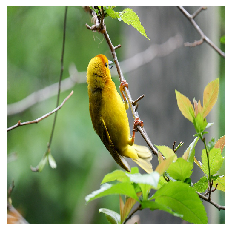

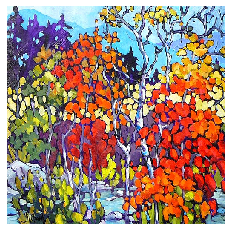

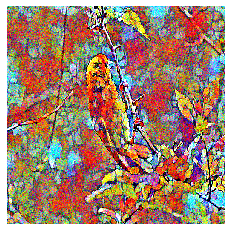

In [74]:
check_for_other_outputs(10)

Saving content_image.jpg to content_image (9).jpg


Saving style_image.jpg to style_image (8).jpg


100%|██████████| 20/20 [01:29<00:00,  4.59s/it]


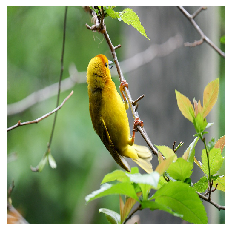

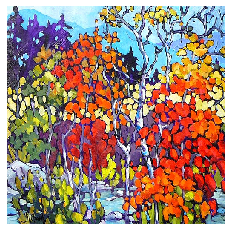

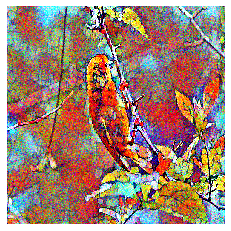

In [75]:
check_for_other_outputs(20)

Saving content_image.jpg to content_image (10).jpg


Saving style_image.jpg to style_image (9).jpg


100%|██████████| 50/50 [03:44<00:00,  4.58s/it]


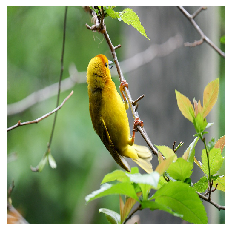

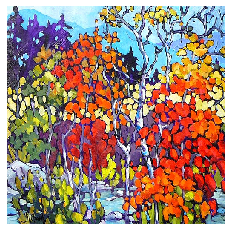

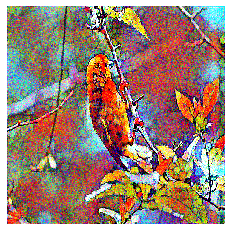

In [76]:
check_for_other_outputs(50)

In [0]:
# it won't work for other images in this function cause all the other operations are defined above are wrt the content image loaded above